# Activation functions comparison

Here we want to evaluate the impact on the performances of different sets of activation functions in our architecture:
1. Only Relu
2. Only sigmoids
3. Relu everywhere except in the last layer sigmoid
4. Leaky Relus everywhere and sigmoid in the last layer

As usual, we work on the MNIST test set binarized (normal class: 0 vs. all the other digits) and use the AU-ROC metrics to compare the model performances. We can also measure how long the model takes to be trained, etc.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.classification import AUCCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)
print(y_test[:5], y_test0[:5])

11493376/11490434 [==============================] - 0s 0us/step
(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)
[7 2 1 0 4] [1 1 1 0 1]


In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=False, activation1="relu",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

In [16]:
from uad.models.variational_autoencoder import ConvolutionalVAE

cvae = ConvolutionalVAE(8)

print(cvae.decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 4, 4, 8)]         0         
_________________________________________________________________
u6 (Conv2DTranspose)         (None, 8, 8, 64)          4672      
_________________________________________________________________
dropout_36 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
activation_73 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
u7 (Conv2DTranspose)         (None, 16, 16, 32)        18464     
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 32)        0   

In [17]:
from uad.models.variational_autoencoder import VAE, Sampling

def build_VAE(activation_functions):
    """
    activation_functions: tuple of activation functions to use (str)
    """
    n_filters = 16
    latent_dim = 8
    latent_side = 4
    batchnorm = False
    dropout = 0.2
    k_size = 3
    
    act1, act2, final_activation = activation_functions

    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(encoder_inputs, paddings, name="pad")

    # contracting path
    x = conv2d_block(x, n_filters * 1, kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout)(x)

    x = conv2d_block(x, n_filters * 2, kernel_size=k_size, batchnorm=batchnorm,
                     activation1=act1, activation2=act2)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout)(x)

    x = conv2d_block(x, n_filters * 4, kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout)(x)

    z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Define decoder model.
    latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), 
                                 name="z_sampling")

    x = layers.Conv2DTranspose(n_filters * 4, (k_size, k_size), strides=(2, 2), 
                               padding='same', name="u6")(
        latent_inputs)
    x = layers.Dropout(dropout)(x)
    x = conv2d_block(x, n_filters * 4, kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)

    x = layers.Conv2DTranspose(n_filters * 2, (k_size, k_size), strides=(2, 2), 
                               padding='same', name="u7")(x)
    x = layers.Dropout(dropout)(x)
    x = conv2d_block(x, n_filters * 2, kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)

    x = layers.Conv2DTranspose(n_filters * 1, (k_size, k_size), strides=(2, 2),
                               padding='same', name="u8")(x)
    x = layers.Dropout(dropout)(x)
    decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm,
                                   activation1=act1, activation2=final_activation)
    crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

    decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")
    
    return VAE(encoder, decoder, latent_dim=latent_dim)

In [19]:
# from uad.callbacks.classification import AUCCallback
# auc_call = AUCCallback(x_train0, y_train0, criterion="l2", pix_threshold=0.7)

tested_activations = np.array([["relu", "relu", "sigmoid"], 
                               ["sigmoid", "sigmoid", "sigmoid"],
                               ["relu", "relu", "relu"],
                               ["relu", "sigmoid", "sigmoid"]])

l_fpr, l_tpr, l_auc = [], [], []
for activations in tested_activations:
    print(activations)
    vae = build_VAE(activations)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.fit(x_train0, x_train0, batch_size=128, epochs=10, callbacks=[auc_call])
    predictions = vae.predict(x_test)
    fpr, tpr, _ = compute_ROC(x_test, predictions, y_test0, criterion="l2")
    auc = compute_AUC(fpr, tpr)
    l_fpr.append(fpr)
    l_tpr.append(tpr)
    l_auc.append(auc)
    
fprs, tprs, aucs = np.array(l_fpr), np.array(l_tpr), np.array(l_auc)

print(aucs)

['relu' 'relu' 'sigmoid']
Epoch 1/10
36/38 [===========================>..] - ETA: 0s - loss: 340.8592 - reconstruction_loss: 338.3051 - kl_loss: 2.5540
AUC = 0.0
38/38 [==============================] - 2s 41ms/step - loss: 328.6199 - reconstruction_loss: 325.8030 - kl_loss: 2.8168
Epoch 2/10
37/38 [============================>.] - ETA: 0s - loss: 135.7162 - reconstruction_loss: 130.6643 - kl_loss: 5.0519
AUC = 0.0
38/38 [==============================] - 1s 32ms/step - loss: 134.6003 - reconstruction_loss: 129.5856 - kl_loss: 5.0147
Epoch 3/10
37/38 [============================>.] - ETA: 0s - loss: 103.0321 - reconstruction_loss: 98.6153 - kl_loss: 4.4168
AUC = 0.0
38/38 [==============================] - 1s 32ms/step - loss: 102.7134 - reconstruction_loss: 98.3053 - kl_loss: 4.4082
Epoch 4/10
37/38 [============================>.] - ETA: 0s - loss: 93.1764 - reconstruction_loss: 89.0452 - kl_loss: 4.1311
AUC = 0.0
38/38 [==============================] - 1s 31ms/step - loss: 93.21

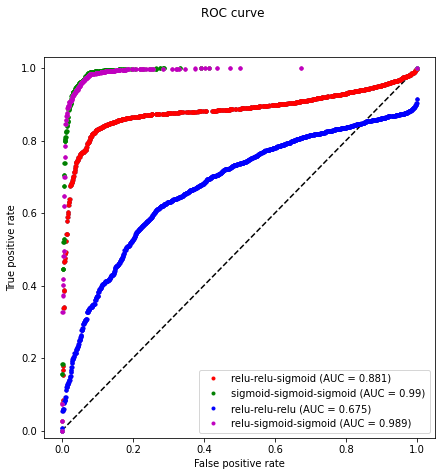

In [21]:
# plot ROC for each dim
labels = [f"{row[0]}-{row[1]}-{row[2]}" for row in tested_activations]
fig, ax = plot_ROC(fprs, tprs, labels)